# Training Sets
### David W. Barker
## Purpose
The purpose of this notebook is to work on the training set creation function in pylinex using a known problem and its known solution.  In this case we will be developing a training set for the turning point model of the 21 cm all sky signal.  We'll apply that model to 21 cm FAST and ARES to see if it fits well.

We need to first start by being able to create a turning point model with some arbitrary parameters.  Let's looks to either ARES or PERSES for that.

In [1]:
# boiler plate
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
import py21cmfast as p21c
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
from pylinex import TrainedBasis
import ares

Here's a visual of the turning point parameters:

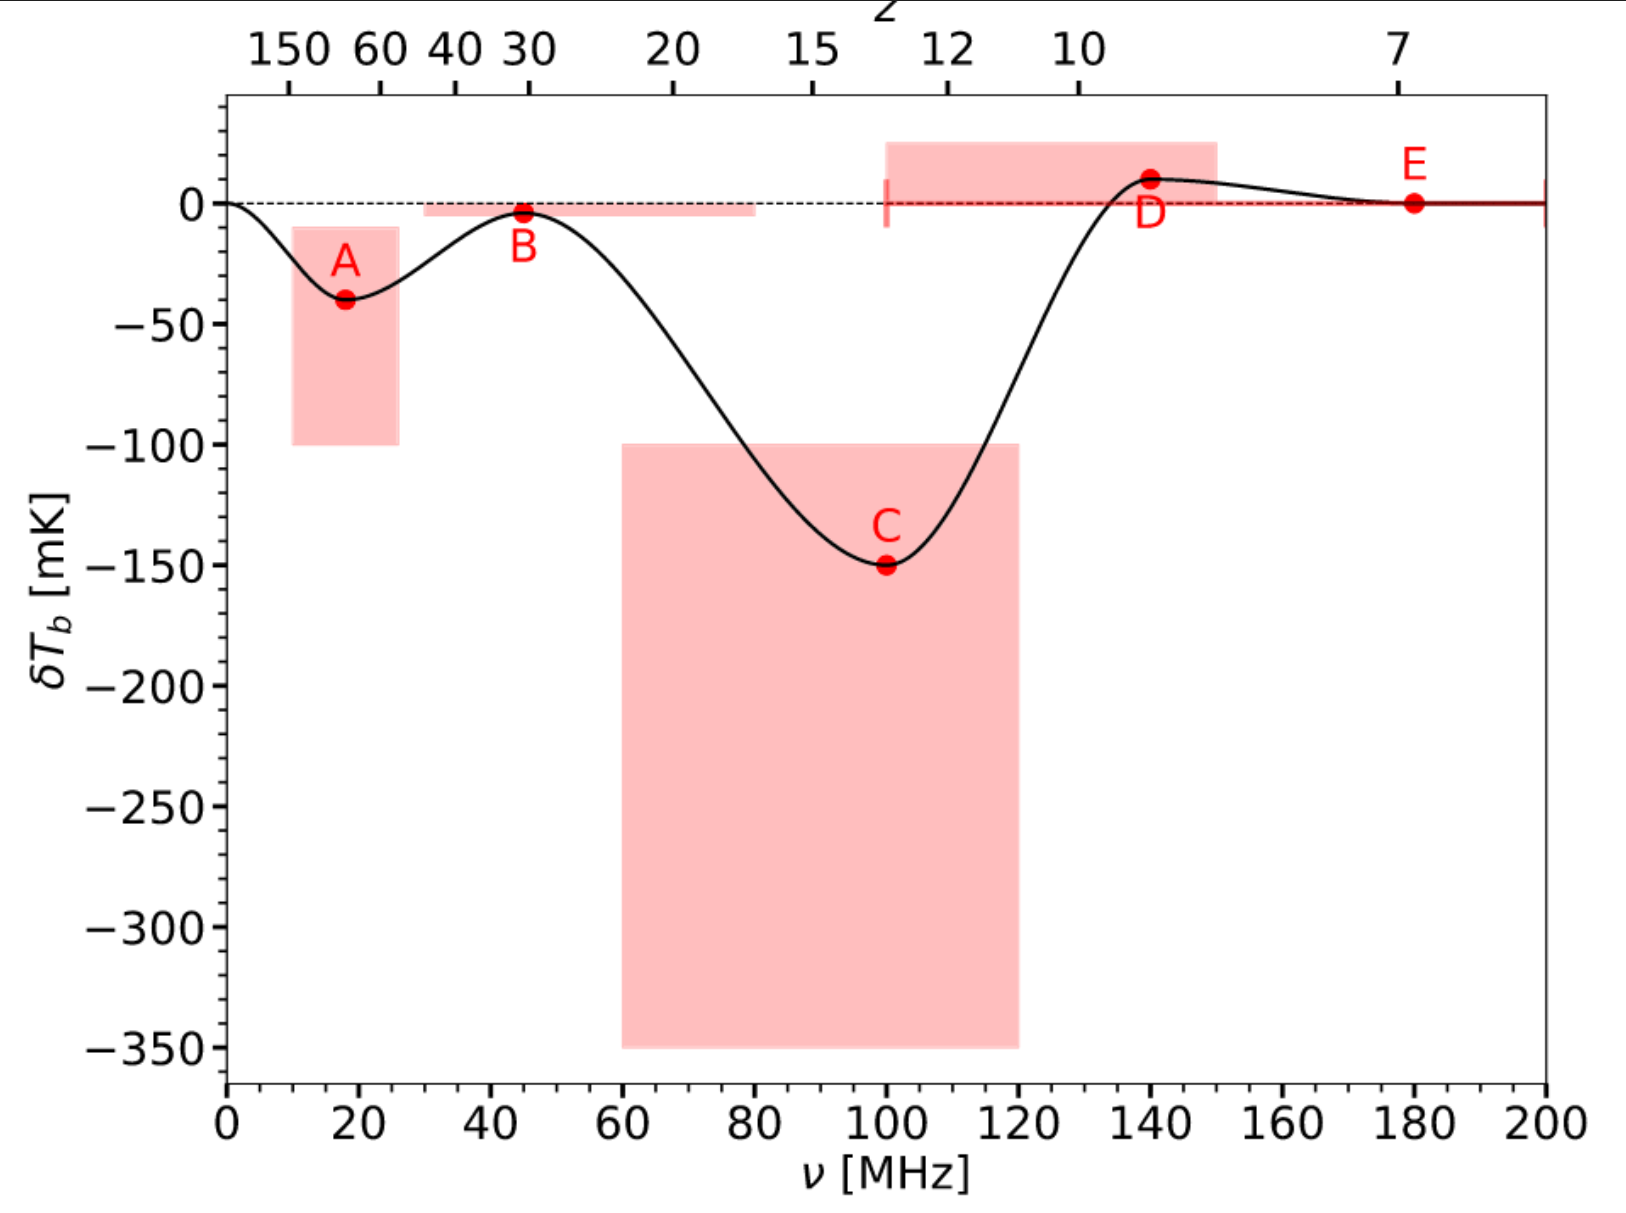

In [5]:
# have to run this here so that the frequencies work out correctly and match the correct model:
sim = ares.simulations.Global21cm()
sim.run()
frequencies_ares=sim.history["nu"]

# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

############################################################################
##                       ARES Simulation: Overview                        ##
############################################################################
## ---------------------------------------------------------------------- ##
## Source Populations                                                     ##
## ---------------------------------------------------------------------- ##
##           sfrd    sed  radio  O/IR  Lya    LW   LyC   Xray  RTE        ##
## pop #0 :  fcoll    yes    -     -     x     x     -     -     -        ##
## pop #1 : sfrd->0   yes    -     -     -     -     -     x     -        ##
## pop #2 : sfrd->0   yes    -     -     -     -     x     -     -        ##
## ---------------------------------------------------------------------- ##
## Physics                                                                ##
## -----

SyntaxError: invalid syntax (1710185882.py, line 1)

Init signature: ares.simulations.Global21cm(**kwargs)
Docstring:     
This class must be inherited by another class, which need only have the
``pf`` attribute.

The three most (only) important parameters are:
    blob_names
    blob_ivars
    blob_funcs
    
Init docstring:
Set up a two-zone model for the global 21-cm signal.

..note :: This is essentially a MultiPhaseMedium calculation, except
    the Lyman alpha background and 21-cm background are calculated,
    and alternative (phenomenological) parameterizations such as a
    tanh for the ionization, thermal, and LW background evolution,
    may be used.
File:           ~/ares/ares/simulations/Global21cm.py
Type:           type
Subclasses:     

In [6]:
# Let's find that turning point model
num_data_points = 2588  # specifies the number of data points for the thetas, phis, and frequencies (maybe separate frequency?)
# frequency
frequency_start = 0 #MHz   #doesn't matter if using simulation frequencies, which we usually do
frequency_end = 200  #MHz  #doesn't matter if using simulation frequencies, which we usually do
frequency_increment = np.abs((frequency_start-frequency_end)/num_data_points)
frequencies=frequencies_ares  # these MUST match the simulation you're running. I'm working on ARES right
                              # now so this is good, but will need to change that for 21cmFAST (might
                              # just clone this down below instead)
# frequencies = np.arange(frequency_start,frequency_end,frequency_increment)  # frequency in Hz
# Note on parameters:parameters: array of length 9, containing A_frequency, B_frequency,
 #                   C_frequency, D_frequency, E_frequency, A_temperature,
 #                   B_temperature, C_temperature, D_temperature. Temperatures
 #                   should be given in mK even if in_Kelvin is True
parameters = np.array([20,45,100,140,180,-50,-5,-150,20])   # parameters defining the turning point model.  Must be 9
Turning_Point = perses.models.TunableTurningPointModel(frequencies)   # creates the turning point object
turning_point_array=Turning_Point(parameters) 

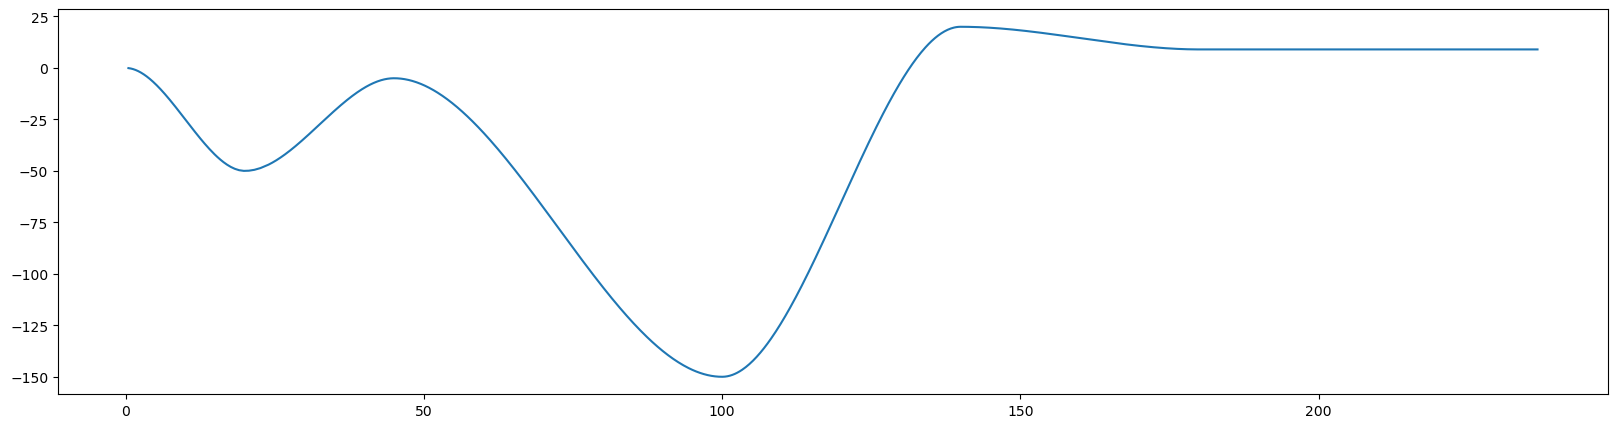

In [7]:
fig=plt.figure(figsize=(20,5))
plt.plot(frequencies,turning_point_array)

We now have the turning point model figured out. Easy enough.  Let's now create a bunch of random turning point parameters for a bunch of random turning point models.  This will be our training set.

In [8]:
# Let's first make a function that can input a start and end point and create an array of values based
# on the number of random runs you want.
def random_parameter (start,end,N):
    """Creates an 1D array of length N populated by random numbers between start and end argument"""
    random_parameter_array = np.array([])
    for i in np.arange(N):
        element = (end-start)*np.random.random() + start
        random_parameter_array = np.append(random_parameter_array,element)
    return random_parameter_array

In [9]:
# creates a bunch of random turning point parameters, but ensures they are still sequentially increasing
# note:  (b - a) * random() + a for random between a and b
# To make it easy, I'm just going to ensure that none of the parameters have a variation that allows
# them to no longer be properly sequential, even though the graphic of their range would imply that
# could happen. (I know, I'm simplifying, but I think that's fine for this toy problem).

### Variations:
## A_frequency = 10-25 MHz
## B_frequency = 30-60 MHz
## C_frequency = 60-110 MHz
## D_frequency = 110-150 MHz
## E_frequency = 150-200 MHz
## A_temperature = -10 to -100 mK
## B_temperature = 0 to -5 mK
## C_temperature = -100 to -350 mK
## D_temperature = 0 to 30 mK
## E_temperature = 0 (no variation)

# fps = frequency parameter set
N = 1000   # number of random models to include in the training set
a_fps = random_parameter(10,25,N)
b_fps = random_parameter(30,60,N)
c_fps = random_parameter(60,110,N)
d_fps = random_parameter(110,150,N)
e_fps = random_parameter(150,200,N)
# tps = temperature parameter set
a_tps = random_parameter(-10,-100,N)
b_tps = random_parameter(0,-5,N)
c_tps = random_parameter(-100,-350,N)
d_tps = random_parameter(0,30,N)

# now lets put all these parameters into individual parameter arrays to put into the turning point model
training_set_parameters_array = np.zeros((N,9))
for i in np.arange(N):
    training_set_parameters_array[i][0] = a_fps[i]
    training_set_parameters_array[i][1] = b_fps[i]
    training_set_parameters_array[i][2] = c_fps[i]
    training_set_parameters_array[i][3] = d_fps[i]
    training_set_parameters_array[i][4] = e_fps[i]
    training_set_parameters_array[i][5] = a_tps[i]
    training_set_parameters_array[i][6] = b_tps[i]
    training_set_parameters_array[i][7] = c_tps[i]
    training_set_parameters_array[i][8] = d_tps[i]

# now lets create a 2D array of turning point models that will be N x number of data points in each model
training_set_array = np.zeros((N,num_data_points))  # requires you run a few cells up for num_data_points
for j in np.arange(N):
    training_set_array[j] = Turning_Point(training_set_parameters_array[j])

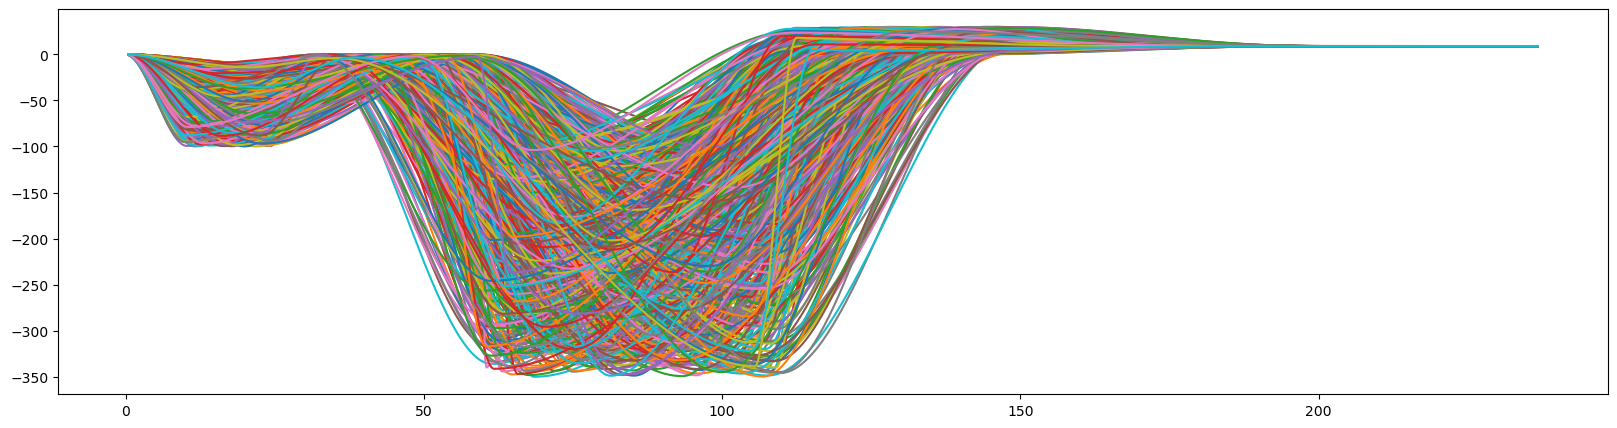

In [10]:
# let's graph the training set:
fig=plt.figure(figsize=(20,5))
for k in training_set_array:
    plt.plot(frequencies,k)

Now that we have our training set, let's make the basis using pylinex:

In [11]:
# Here is the basis. Pretty straight forward
signal_basis = TrainedBasis(training_set=training_set_array, num_basis_vectors=20)

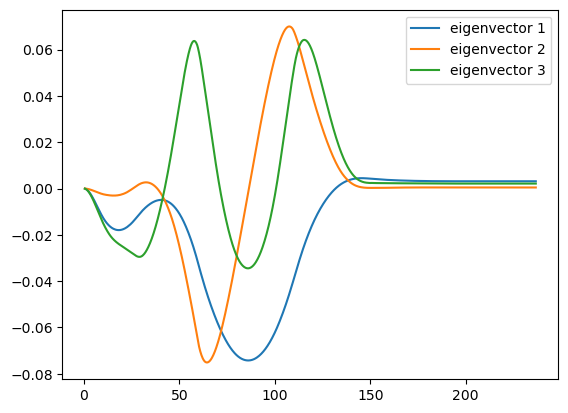

In [12]:
# Plots the eignevalues up to some vector number (plotting all 20 can be a bit too much)
eigen_vector_count = 3  # number of eigenvectors to plot
for i in np.arange(eigen_vector_count):
    plt.plot(frequencies,signal_basis.basis[i],label = f"eigenvector {i+1}")
plt.legend()

Now we need to apply pylinex's fitting routine to some signal.  Let's see if we can find the signal function in ARES:

(<Axes: xlabel='$\\nu \\ (\\mathrm{MHz})$', ylabel='$\\delta T_b \\ (\\mathrm{mK})$'>,
 <Axes: xlabel='$z$'>)

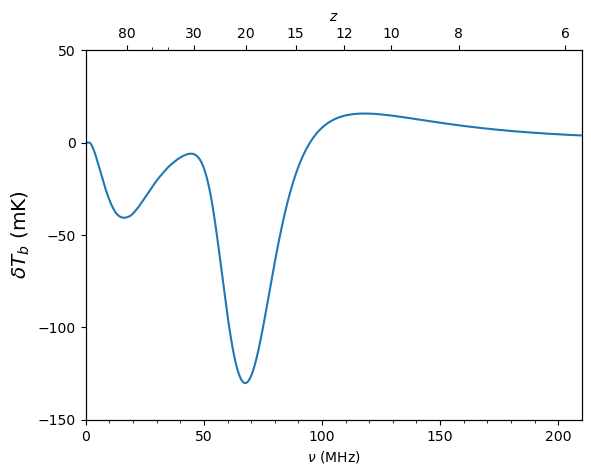

In [13]:
# figured out how to run the ARES simulation:
### I've commented the first two lines out because we run this earlier in the notebook now so that the 
### turning_point_model can use the exact same frequency range
# sim = ares.simulations.Global21cm()
# sim.run()
sim.GlobalSignature()  # plots the data

So this runs the global 21 cm simulation from ARES (quite fast, too).  Now we need to find a way to extract the data in array form.  Probably in sim.history


In [14]:
# grabs some imporant data from the ARES simulation you just ran
dTb=sim.history["dTb"]     # difference in the global 21 cm temperature from the CMB
frequencies_ares=sim.history["nu"]     # frequencies used in the sim (already defined earlier so freqs match)
redshifts_ares=sim.history["z"]     # redshifts used in the sim

Now we can try to fit that linear model we made earlier in pylinex to the data we just simulated.

RMS residual = 0.72 mK


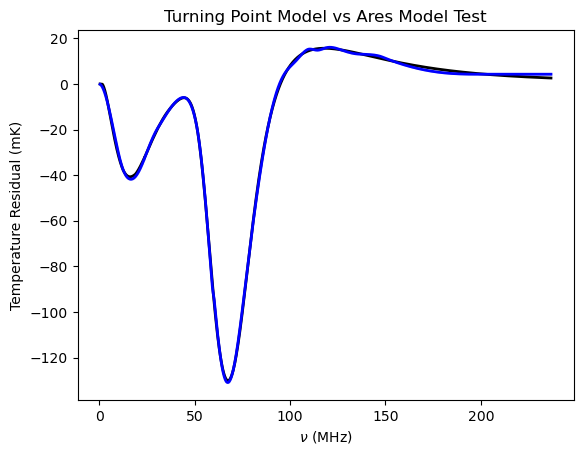

In [15]:
basis_sum = BasisSum(names=['turning_point_model'], bases=[signal_basis])
fitter = Fitter(basis_sum=basis_sum, data=dTb, error=None)
rms_residual = fitter.channel_bias_RMS
print('RMS residual = %.2f mK' % rms_residual)
#The Fitter class also has several plotting methods to view the results of the fit
fitter.plot_subbasis_fit(nsigma=1, name='turning_point_model', x_values=frequencies, subtract_truth=False,\
    true_curve=dTb, colors='b', xlabel=r'$\nu$ (MHz)', ylabel='Temperature Residual (mK)',\
    title='Turning Point Model vs Ares Model Test', show=True)

RMS residual = 0.72 mK


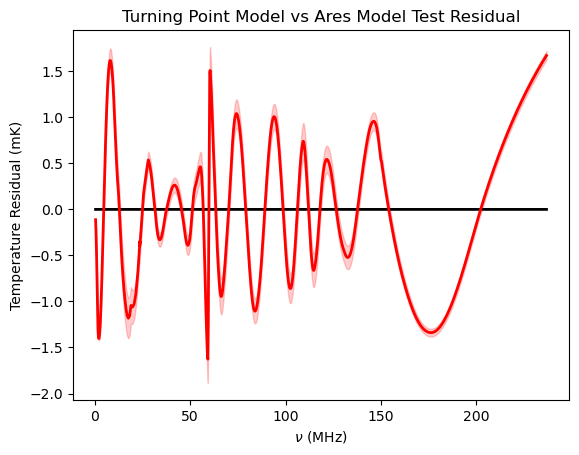

In [16]:
print('RMS residual = %.2f mK' % rms_residual)
fitter.plot_subbasis_fit(nsigma=1, name='turning_point_model', x_values=frequencies, subtract_truth=True,\
    true_curve=dTb, colors='r', xlabel=r'$\nu$ (MHz)', ylabel='Temperature Residual (mK)',\
    title='Turning Point Model vs Ares Model Test Residual', show=True)

This all works great, except you have to change the frequencies at the top from our arbitrarily defined frequencies to the ARES frequencies.  Kinda bugs me, especially since you have to run it down here, then up there.  To fix this I added some of the simulation code to the very beginning of the notebook and commented it out when I run into down the road.

Now we need to run the code for the 21 cm Fast version of this:

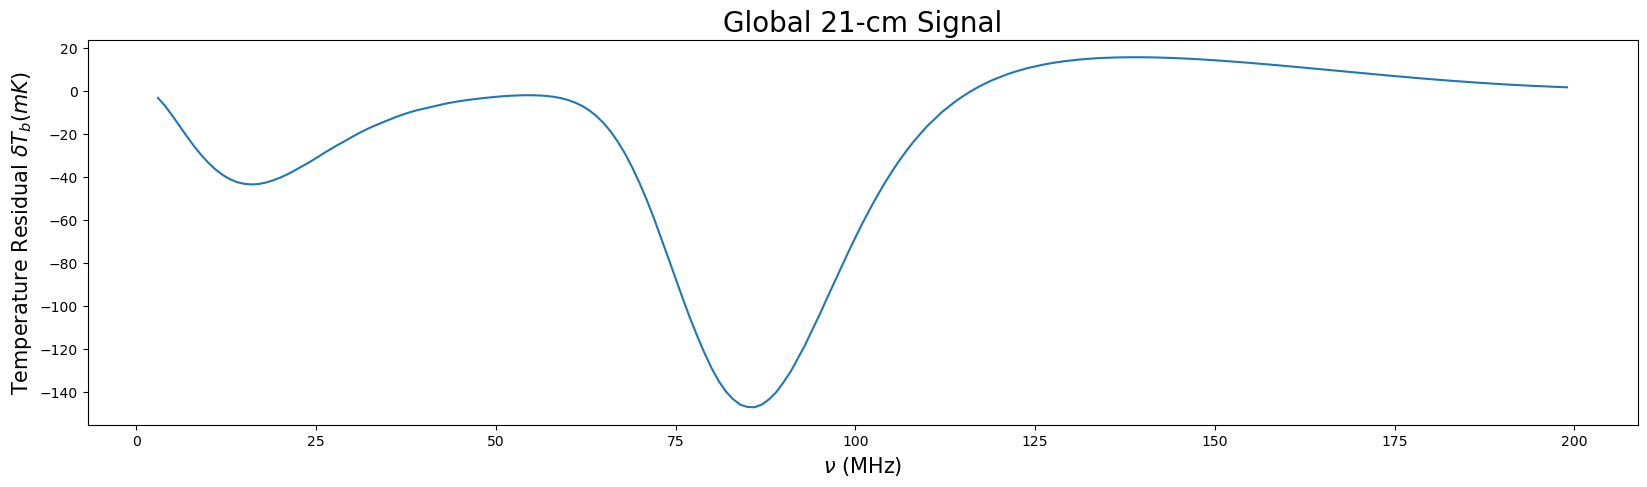

In [3]:
# 21 cm FAST seems to not appreciate any z value (redshift) of 500 or more. Puts the lower limit of the 
# frequency at around 3 MHZ.  Ideal would be 1 MHz, but LuSEE-Night is at 5 MHz, so I suppose that will
# be fine.  May want to look into getting that down to 1 somehow someday, but not right now.
frequencies_21cm = np.arange(3,200)  # avoiding anything below 2.5 MHZ
z = lambda f: 1420.4/f-1
z_array = np.array([])
for i in frequencies_21cm:
    element = z(i)
    z_array=np.append(z_array,element)
# Now let's plug in the redshifts
coeval_boxes = p21c.run_coeval(
    redshift = list(z_array),
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(),
    astro_params = p21c.AstroParams(),
    flag_options = {'USE_TS_FLUCT':True},
    random_seed=12345)
# Let's make our 21cm curve from the data!
global21cm_array=np.array([])
for i in range(len(frequencies_21cm)):
    element=coeval_boxes[i].brightness_temp.mean()
    global21cm_array=np.append(global21cm_array,element)

# This will plot our data over our frequencies_21cm
fig=plt.figure(figsize=(20,5))
plt.plot(frequencies_21cm,global21cm_array)
plt.xlabel(r'$\nu$ (MHz)',size=15)
plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
plt.title("Global 21-cm Signal", size = 20)
plt.show()

Here's the issue I'm having now.  This runs fast because I've already cached this range of frequencies, and as you can see it looks good too.  The issue is that ARES has a far different range of frequencies and a much higher resolution (that is largely unneccessary I think), so let's bring the ARES array down to the same resolution as this array...somehow.  The alternative is taking the 10 some odd hours to run all the ARES frequencies. Not a great use of time me thinks.

In [17]:
print(f"ARES shape = {dTb.shape[0]}\n21 cm FAST shape = {global21cm_array.shape[0]}")

ARES shape = 2588
21 cm FAST shape = 197


We need to collapse ARES into the same shape as 21 cm FAST, but in a way that matches the frequencies most closely. It won't be perfect, but it'll have to do for now.

In [18]:
collapsed_ARES_array = np.array([])
for a in frequencies_21cm:
    element = dTb[np.argmin(np.abs(frequencies_ares - a))] # this selects the value of dTb that corresponds to the closest frequency value from the 21cm frequency set
    collapsed_ARES_array = np.append(collapsed_ARES_array,element)

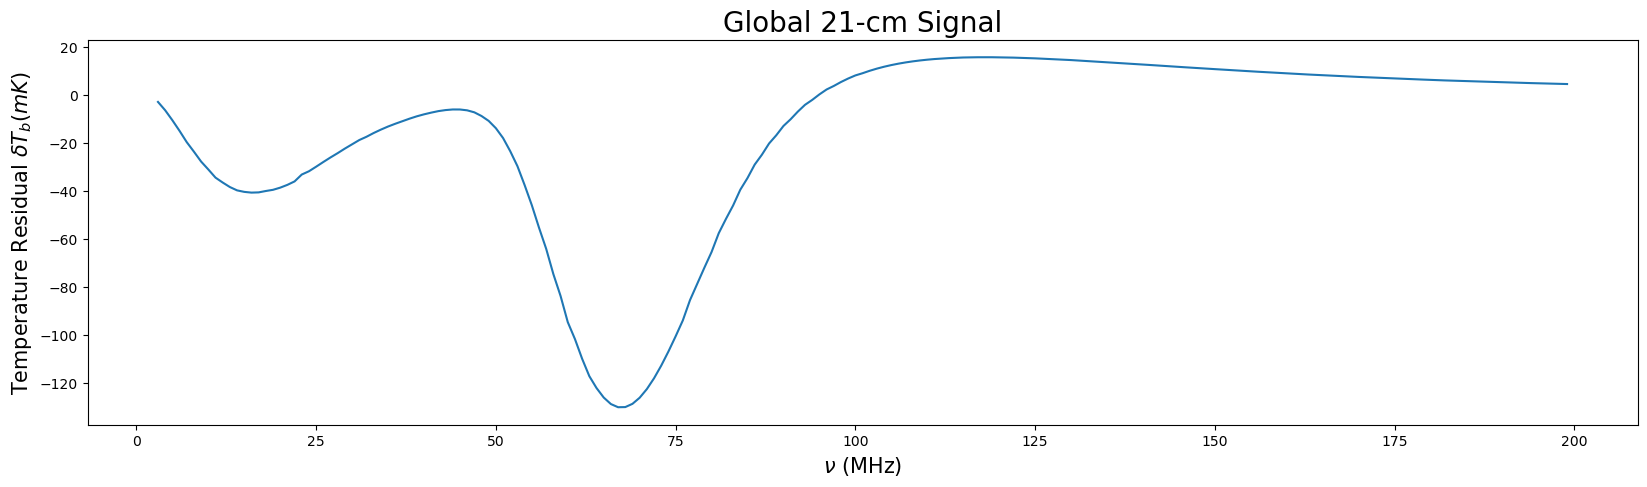

In [19]:
# this plots the new collapsed ARES data. Should look similar to the old, just with different bounds
fig=plt.figure(figsize=(20,5))
plt.plot(frequencies_21cm,collapsed_ARES_array)
plt.xlabel(r'$\nu$ (MHz)',size=15)
plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
plt.title("Global 21-cm Signal", size = 20)
plt.show()

Now we need to create a model that has the same shape.  Let's run the entire fitter process again, but with this new lower resolution:

In [20]:
# Let's find that turning point model
num_data_points = frequencies_21cm.shape[0]  # specifies the number of data points for the thetas, phis, and frequencies (maybe separate frequency?)
# frequency
# frequency_start = 0 #MHz   #doesn't matter if using simulation frequencies, which we usually do
# frequency_end = 200  #MHz  #doesn't matter if using simulation frequencies, which we usually do
# frequency_increment = np.abs((frequency_start-frequency_end)/num_data_points)
frequencies=frequencies_21cm  # these MUST match the simulation you're running. I'm working on ARES right
                              # now so this is good, but will need to change that for 21cmFAST (might
                              # just clone this down below instead)
# frequencies = np.arange(frequency_start,frequency_end,frequency_increment)  # frequency in Hz
# Note on parameters:parameters: array of length 9, containing A_frequency, B_frequency,
 #                   C_frequency, D_frequency, E_frequency, A_temperature,
 #                   B_temperature, C_temperature, D_temperature. Temperatures
 #                   should be given in mK even if in_Kelvin is True
parameters = np.array([20,45,100,140,180,-50,-5,-150,20])   # parameters defining the turning point model.  Must be 9
Turning_Point = perses.models.TunableTurningPointModel(frequencies)   # creates the turning point object
turning_point_array=Turning_Point(parameters) 

# Let's first make a function that can input a start and end point and create an array of values based
# on the number of random runs you want.
def random_parameter (start,end,N):
    """Creates an 1D array of length N populated by random numbers between start and end argument"""
    random_parameter_array = np.array([])
    for i in np.arange(N):
        element = (end-start)*np.random.random() + start
        random_parameter_array = np.append(random_parameter_array,element)
    return random_parameter_array

# creates a bunch of random turning point parameters, but ensures they are still sequentially increasing
# note:  (b - a) * random() + a for random between a and b
# To make it easy, I'm just going to ensure that none of the parameters have a variation that allows
# them to no longer be properly sequential, even though the graphic of their range would imply that
# could happen. (I know, I'm simplifying, but I think that's fine for this toy problem).

### Variations:
## A_frequency = 10-25 MHz
## B_frequency = 30-60 MHz
## C_frequency = 60-110 MHz
## D_frequency = 110-150 MHz
## E_frequency = 150-200 MHz
## A_temperature = -10 to -100 mK
## B_temperature = 0 to -5 mK
## C_temperature = -100 to -350 mK
## D_temperature = 0 to 30 mK
## E_temperature = 0 (no variation)

# fps = frequency parameter set
N = 1000   # number of random models to include in the training set
a_fps = random_parameter(10,25,N)
b_fps = random_parameter(30,60,N)
c_fps = random_parameter(60,110,N)
d_fps = random_parameter(110,150,N)
e_fps = random_parameter(150,200,N)
# tps = temperature parameter set
a_tps = random_parameter(-10,-100,N)
b_tps = random_parameter(0,-5,N)
c_tps = random_parameter(-100,-350,N)
d_tps = random_parameter(0,30,N)

# now lets put all these parameters into individual parameter arrays to put into the turning point model
training_set_parameters_array = np.zeros((N,9))
for i in np.arange(N):
    training_set_parameters_array[i][0] = a_fps[i]
    training_set_parameters_array[i][1] = b_fps[i]
    training_set_parameters_array[i][2] = c_fps[i]
    training_set_parameters_array[i][3] = d_fps[i]
    training_set_parameters_array[i][4] = e_fps[i]
    training_set_parameters_array[i][5] = a_tps[i]
    training_set_parameters_array[i][6] = b_tps[i]
    training_set_parameters_array[i][7] = c_tps[i]
    training_set_parameters_array[i][8] = d_tps[i]

# now lets create a 2D array of turning point models that will be N x number of data points in each model
training_set_array = np.zeros((N,num_data_points))  # requires you run a few cells up for num_data_points
for j in np.arange(N):
    training_set_array[j] = Turning_Point(training_set_parameters_array[j])

# Here is the basis. Pretty straight forward
signal_basis = TrainedBasis(training_set=training_set_array, num_basis_vectors=20)

# grabs some imporant data from the ARES simulation you just ran
dTb=sim.history["dTb"]     # difference in the global 21 cm temperature from the CMB
frequencies_ares=sim.history["nu"]     # frequencies used in the sim (already defined earlier so freqs match)
redshifts_ares=sim.history["z"]     # redshifts used in the sim

RMS residual = 0.47 mK


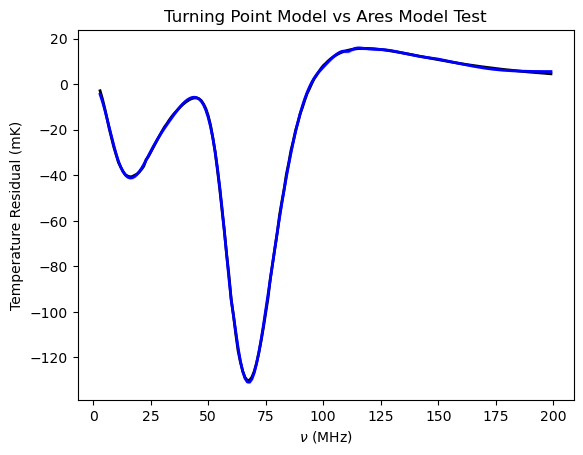

In [21]:
basis_sum = BasisSum(names=['turning_point_model'], bases=[signal_basis])
fitter = Fitter(basis_sum=basis_sum, data=collapsed_ARES_array, error=None)
rms_residual = fitter.channel_bias_RMS
print('RMS residual = %.2f mK' % rms_residual)
#The Fitter class also has several plotting methods to view the results of the fit
fitter.plot_subbasis_fit(nsigma=1, name='turning_point_model', x_values=frequencies, subtract_truth=False,\
    true_curve=collapsed_ARES_array, colors='b', xlabel=r'$\nu$ (MHz)', ylabel='Temperature Residual (mK)',\
    title='Turning Point Model vs Ares Model Test', show=True)

RMS residual = 0.47 mK


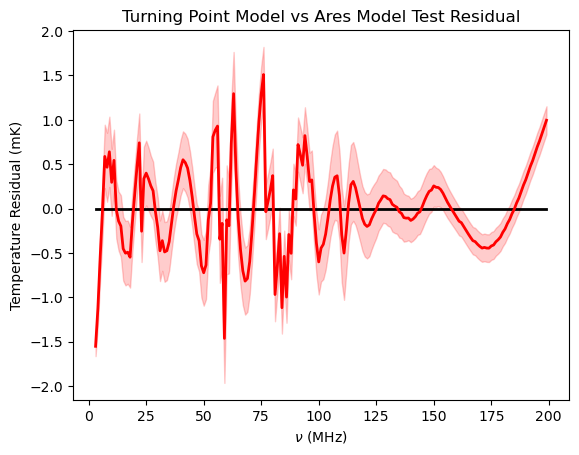

In [22]:
print('RMS residual = %.2f mK' % rms_residual)
fitter.plot_subbasis_fit(nsigma=1, name='turning_point_model', x_values=frequencies_21cm, subtract_truth=True,\
    true_curve=collapsed_ARES_array, colors='r', xlabel=r'$\nu$ (MHz)', ylabel='Temperature Residual (mK)',\
    title='Turning Point Model vs Ares Model Test Residual', show=True)

RMS residual = 1.21 mK


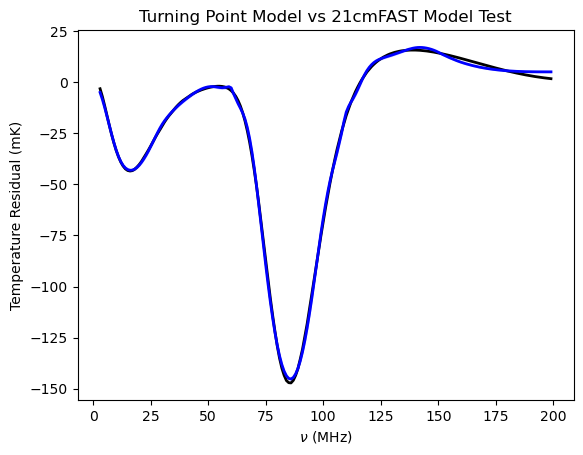

In [23]:
basis_sum = BasisSum(names=['turning_point_model'], bases=[signal_basis])
fitter = Fitter(basis_sum=basis_sum, data=global21cm_array, error=None)
rms_residual = fitter.channel_bias_RMS
print('RMS residual = %.2f mK' % rms_residual)
#The Fitter class also has several plotting methods to view the results of the fit
fitter.plot_subbasis_fit(nsigma=1, name='turning_point_model', x_values=frequencies, subtract_truth=False,\
    true_curve=global21cm_array, colors='b', xlabel=r'$\nu$ (MHz)', ylabel='Temperature Residual (mK)',\
    title='Turning Point Model vs 21cmFAST Model Test', show=True)

RMS residual = 1.21 mK


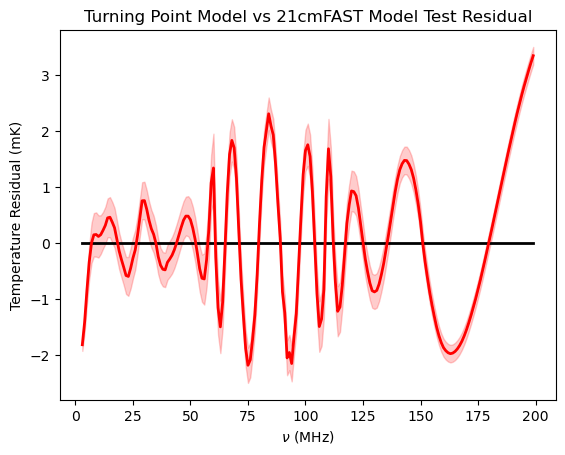

In [24]:
print('RMS residual = %.2f mK' % rms_residual)
fitter.plot_subbasis_fit(nsigma=1, name='turning_point_model', x_values=frequencies_21cm, subtract_truth=True,\
    true_curve=global21cm_array, colors='r', xlabel=r'$\nu$ (MHz)', ylabel='Temperature Residual (mK)',\
    title='Turning Point Model vs 21cmFAST Model Test Residual', show=True)

It would be nice to compare 21cmFAST with ARES. I care about the dark ages, not really the cosmic dawn, so let's focus on frequencies below 40 MHz.  I would like to just see a plot of them on top of eachother first:

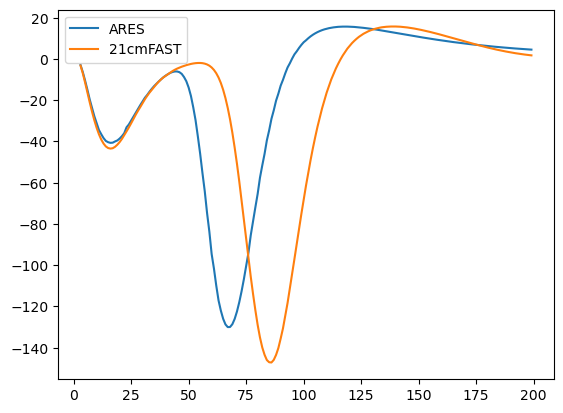

In [25]:
plt.plot(frequencies_21cm,collapsed_ARES_array,label="ARES")
plt.plot(frequencies_21cm,global21cm_array,label="21cmFAST")
plt.legend()

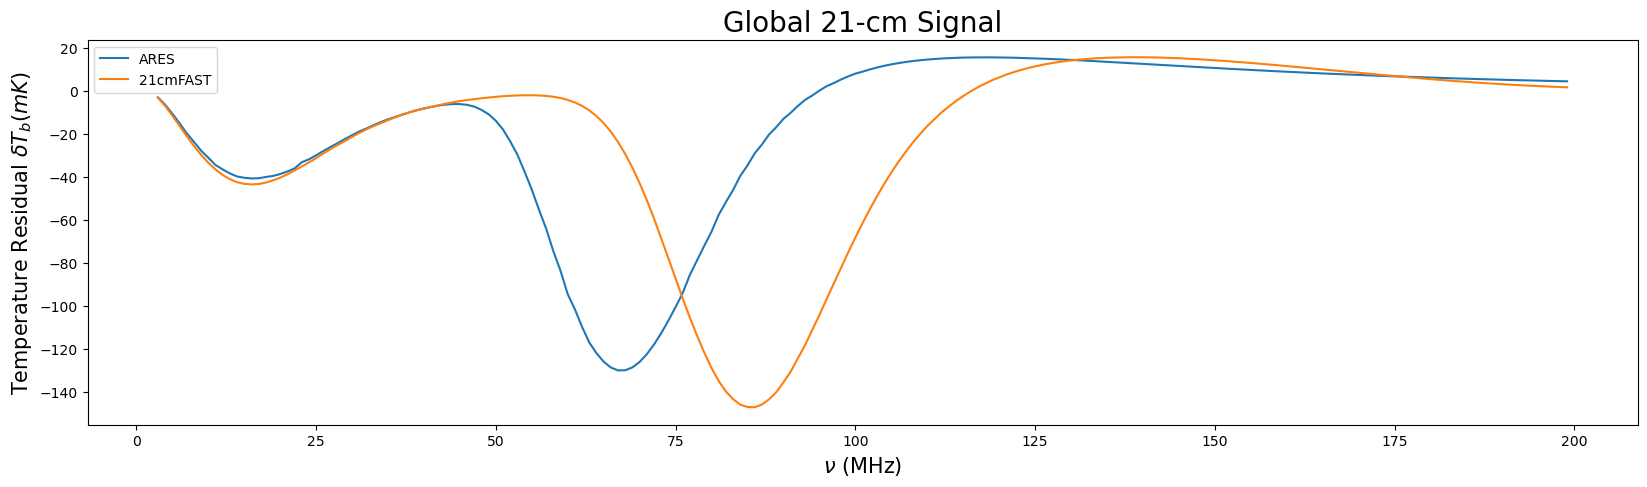

In [26]:
fig=plt.figure(figsize=(20,5))
plt.plot(frequencies_21cm,collapsed_ARES_array,label="ARES")
plt.plot(frequencies_21cm,global21cm_array,label="21cmFAST")
plt.xlabel(r'$\nu$ (MHz)',size=15)
plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
plt.title("Global 21-cm Signal", size = 20)
plt.legend()
plt.show()

Let's zoom in to the part we care about:

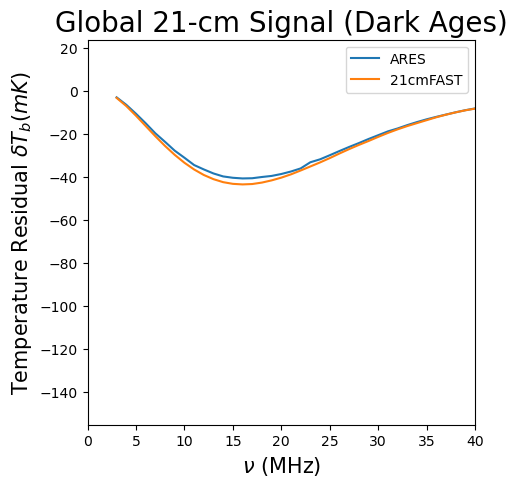

In [27]:
fig=plt.figure(figsize=(5,5))
plt.plot(frequencies_21cm,collapsed_ARES_array,label="ARES")
plt.plot(frequencies_21cm,global21cm_array,label="21cmFAST")
plt.xlabel(r'$\nu$ (MHz)',size=15)
plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
plt.title("Global 21-cm Signal (Dark Ages)", size = 20)
plt.xlim(0,40)
plt.legend()
plt.show()

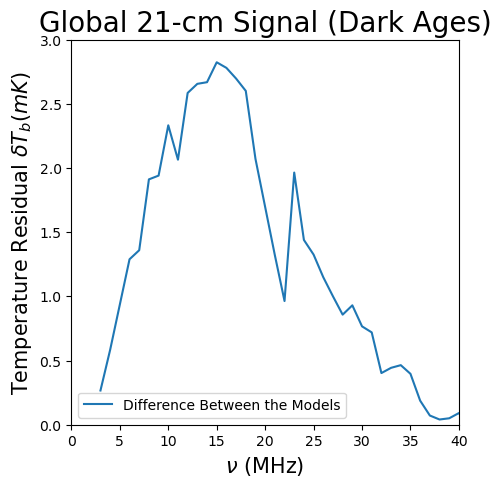

In [28]:
fig=plt.figure(figsize=(5,5))
plt.plot(frequencies_21cm,collapsed_ARES_array-global21cm_array,label="Difference Between the Models")

plt.xlabel(r'$\nu$ (MHz)',size=15)
plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
plt.title("Global 21-cm Signal (Dark Ages)", size = 20)
plt.xlim(0,40)
plt.ylim(0,3)
plt.legend()
plt.show()

Here are 21cmFAST parameters (last column)

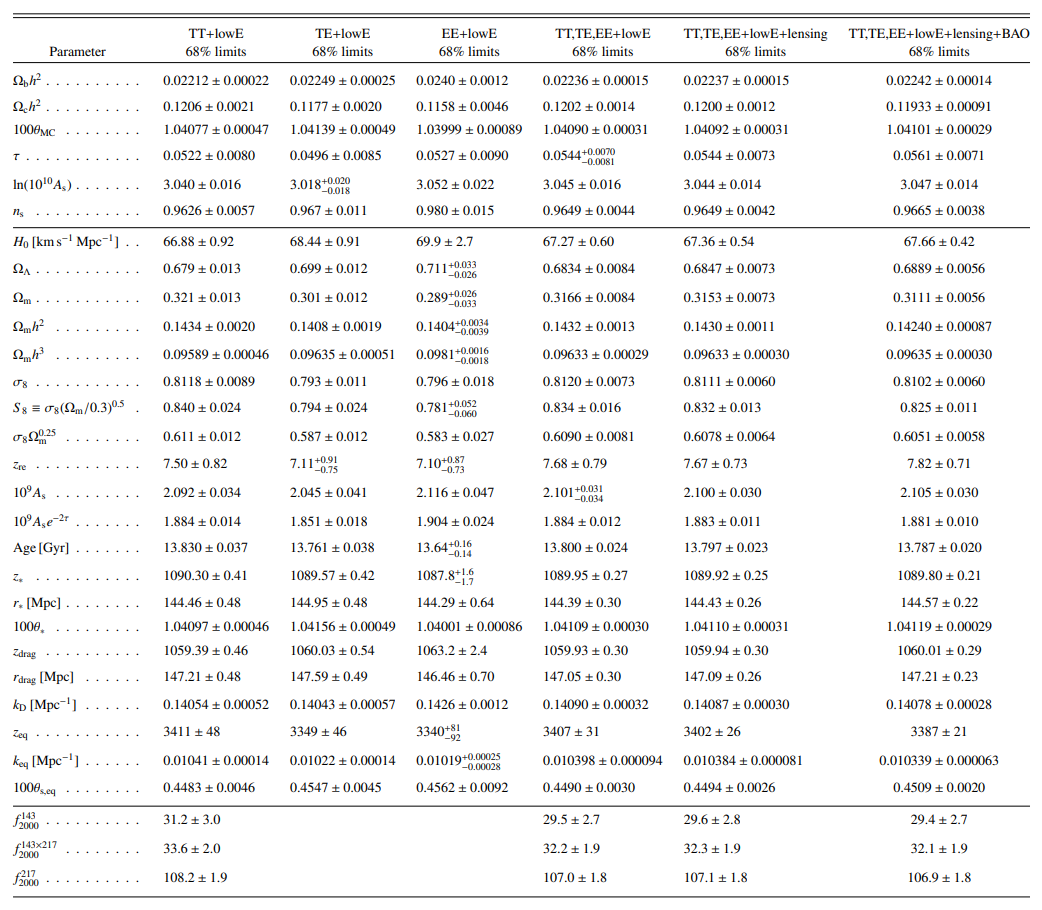

The table below is (not sure which column) shows the ARES parameters 

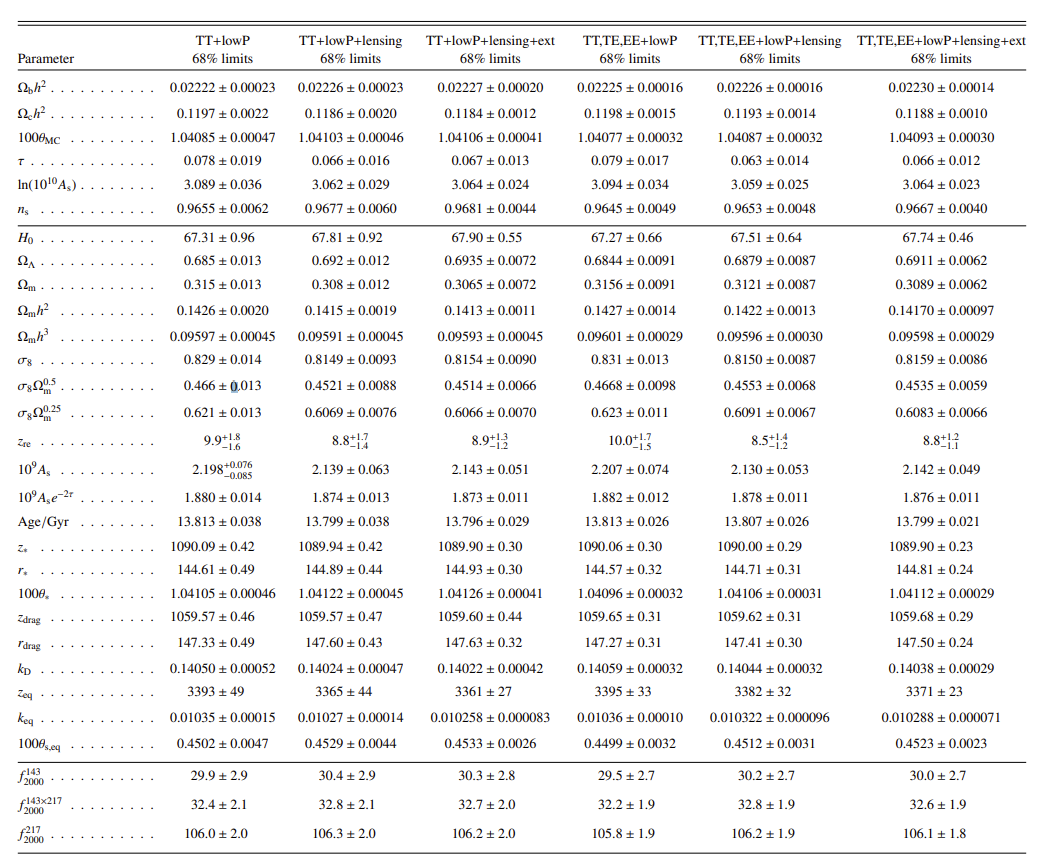

Or maybe this:

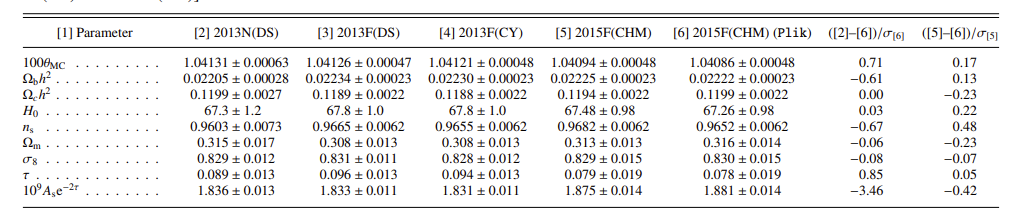

Ares parameters: Ωb = 0.049, h = 0.6711, ns = 0.9624, w = − 1, ∑ mν = 0, and ΩK = 0

TO DO:
- Parameters, find what they are
- Add noise to data?
- Change the number of eignevectors (play around with that or just let BPIC deal with it)